In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

In [2]:
from keras.datasets import mnist

(x_train,y_train), (x_test,y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print('training data:{}'.format(x_train.shape))
print('training labels:{}'.format(y_train.shape))

training data:(60000, 28, 28)
training labels:(60000,)


In [4]:
print('testing data: {}'.format(x_test.shape))
print('testing labels: {}'.format(y_test.shape))

testing data: (10000, 28, 28)
testing labels: (10000,)


In [5]:
import matplotlib.pyplot as plt

# python magic function
get_ipython().run_line_magic('matplotlib', 'inline')

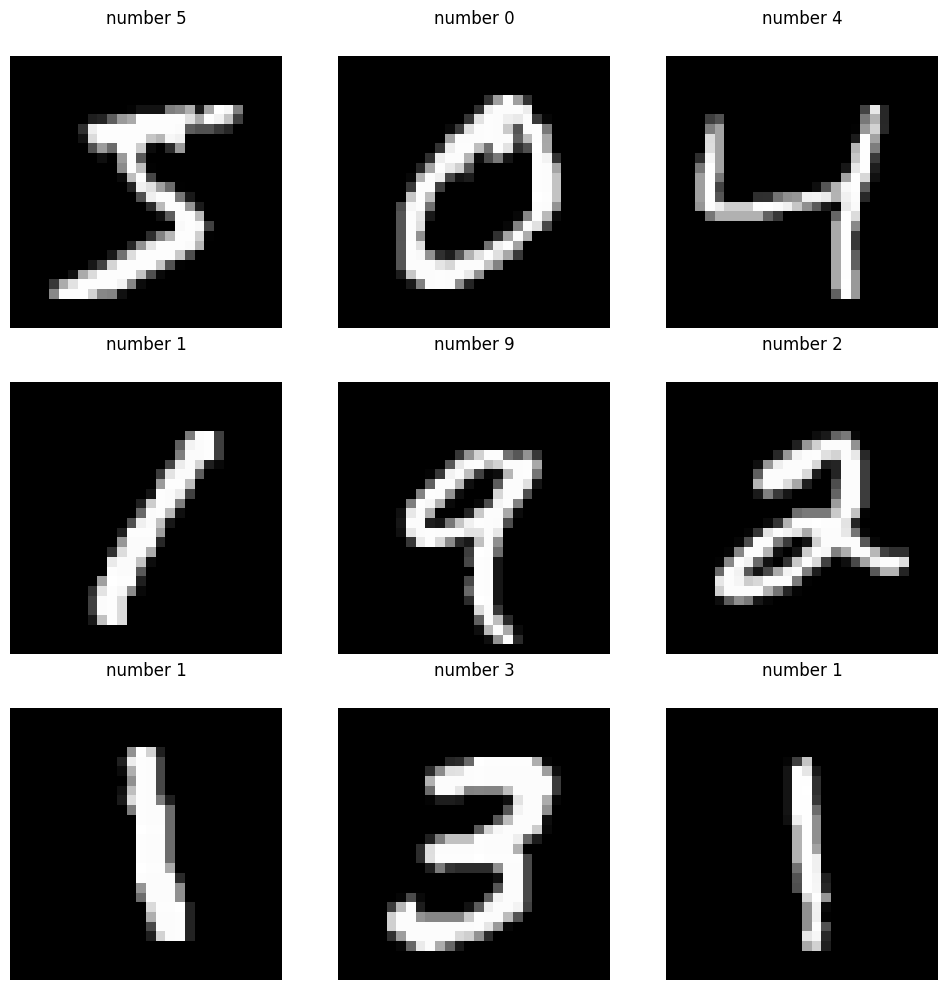

In [6]:
# create a figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3,figsize = (12, 12))
plt.gray()

#loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('number {}'.format(y_train[i]))

# display the figure
fig.show()

In [7]:
# preprocessing the images

# convert each image to 1 dimension array
X = x_train.reshape(len(x_train), -1)
Y = y_train

# normalise the data to 0 -1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [8]:
from sklearn.cluster import MiniBatchKMeans
n_digits = len(np.unique(y_test))
print(n_digits)
# inialise kmeans model
kmeans = MiniBatchKMeans(n_clusters =n_digits)
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [9]:
kmeans.labels_[:20]

array([5, 0, 2, 7, 4, 8, 1, 5, 1, 7, 6, 7, 3, 9, 1, 4, 8, 7, 9, 7],
      dtype=int32)

In [10]:
def infer_cluster_labels(kmeans,actual_labels):
    '''
    associate most probable label with each  cluster in kmeans model
    returns: dictionary  of clusters assigned to each label
    '''

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find the index of points in cluster
        labels=[]
        index = np.where(kmeans.labels_ ==i)

        # append actual labels for each  point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels) == 0:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign cluster to a value in the inferred labels dictionary
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create new array for this key
            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    # empty array of len(X)
    for i , cluster in enumerate(X_labels):
        for key,value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i]= key
    return predicted_labels

In [11]:
# test the infer_cluster_labels() and infer_data-labels() functions
cluster_labels = infer_cluster_labels(kmeans,Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[8 0 4 1 7 2 1 8 1 1 3 1 3 6 1 7 2 1 6 1]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [12]:
# optimizing & evaluating the clustering algorithm

from sklearn import metrics

def calculate_metrics(estimator,data,labels):

    # calculate and print metrics
    print("Number of Clusters:{}".format(estimator.n_clusters))
    print("Inertia:{}".format(estimator.inertia_))
    print("Homogeneity: {}".format(metrics.homogeneity_score(labels,estimator.labels_)))

In [13]:
clusters  = [10,16,36,64,144,256]

In [14]:
# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)

    # print cluster metrics
    calculate_metrics(estimator,X,Y)

    # determine predicted labels
    cluster_labels =  infer_cluster_labels(estimator, Y)
    predicted_Y= infer_data_labels(estimator.labels_,cluster_labels)

    # calculate and print accuracy
    print('accuracy:{}\n'.format(metrics.accuracy_score(Y,predicted_Y)))

Number of Clusters:10
Inertia:2367144.122598007
Homogeneity: 0.4931407337497024
accuracy:0.6152833333333333

Number of Clusters:16
Inertia:2234422.122802542
Homogeneity: 0.5206045197712771
accuracy:0.5947166666666667

Number of Clusters:36
Inertia:1963120.8782698568
Homogeneity: 0.668109812630608
accuracy:0.7502166666666666

Number of Clusters:64
Inertia:1802520.3272948365
Homogeneity: 0.7487043410422796
accuracy:0.8283

Number of Clusters:144
Inertia:1622827.2654713837
Homogeneity: 0.8039766844624475
accuracy:0.8675

Number of Clusters:256
Inertia:1506300.8052161487
Homogeneity: 0.8410810011798904
accuracy:0.8971166666666667



In [15]:
# test kmeans algorithm on testing dataset
#convert each image to 1 dim array
X_test = x_test.reshape(len(x_test),-1)

# normalise the data from 0 - 1
X_test = X_test.astype(float)/255.

#initialize and fit kmeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters=256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans,Y)

# predict labels fro testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(test_clusters,cluster_labels)

# calculate and print accuracy
print("testing accuracy: {}".format(metrics.accuracy_score(y_test, predicted_labels)))

testing accuracy: 0.9015


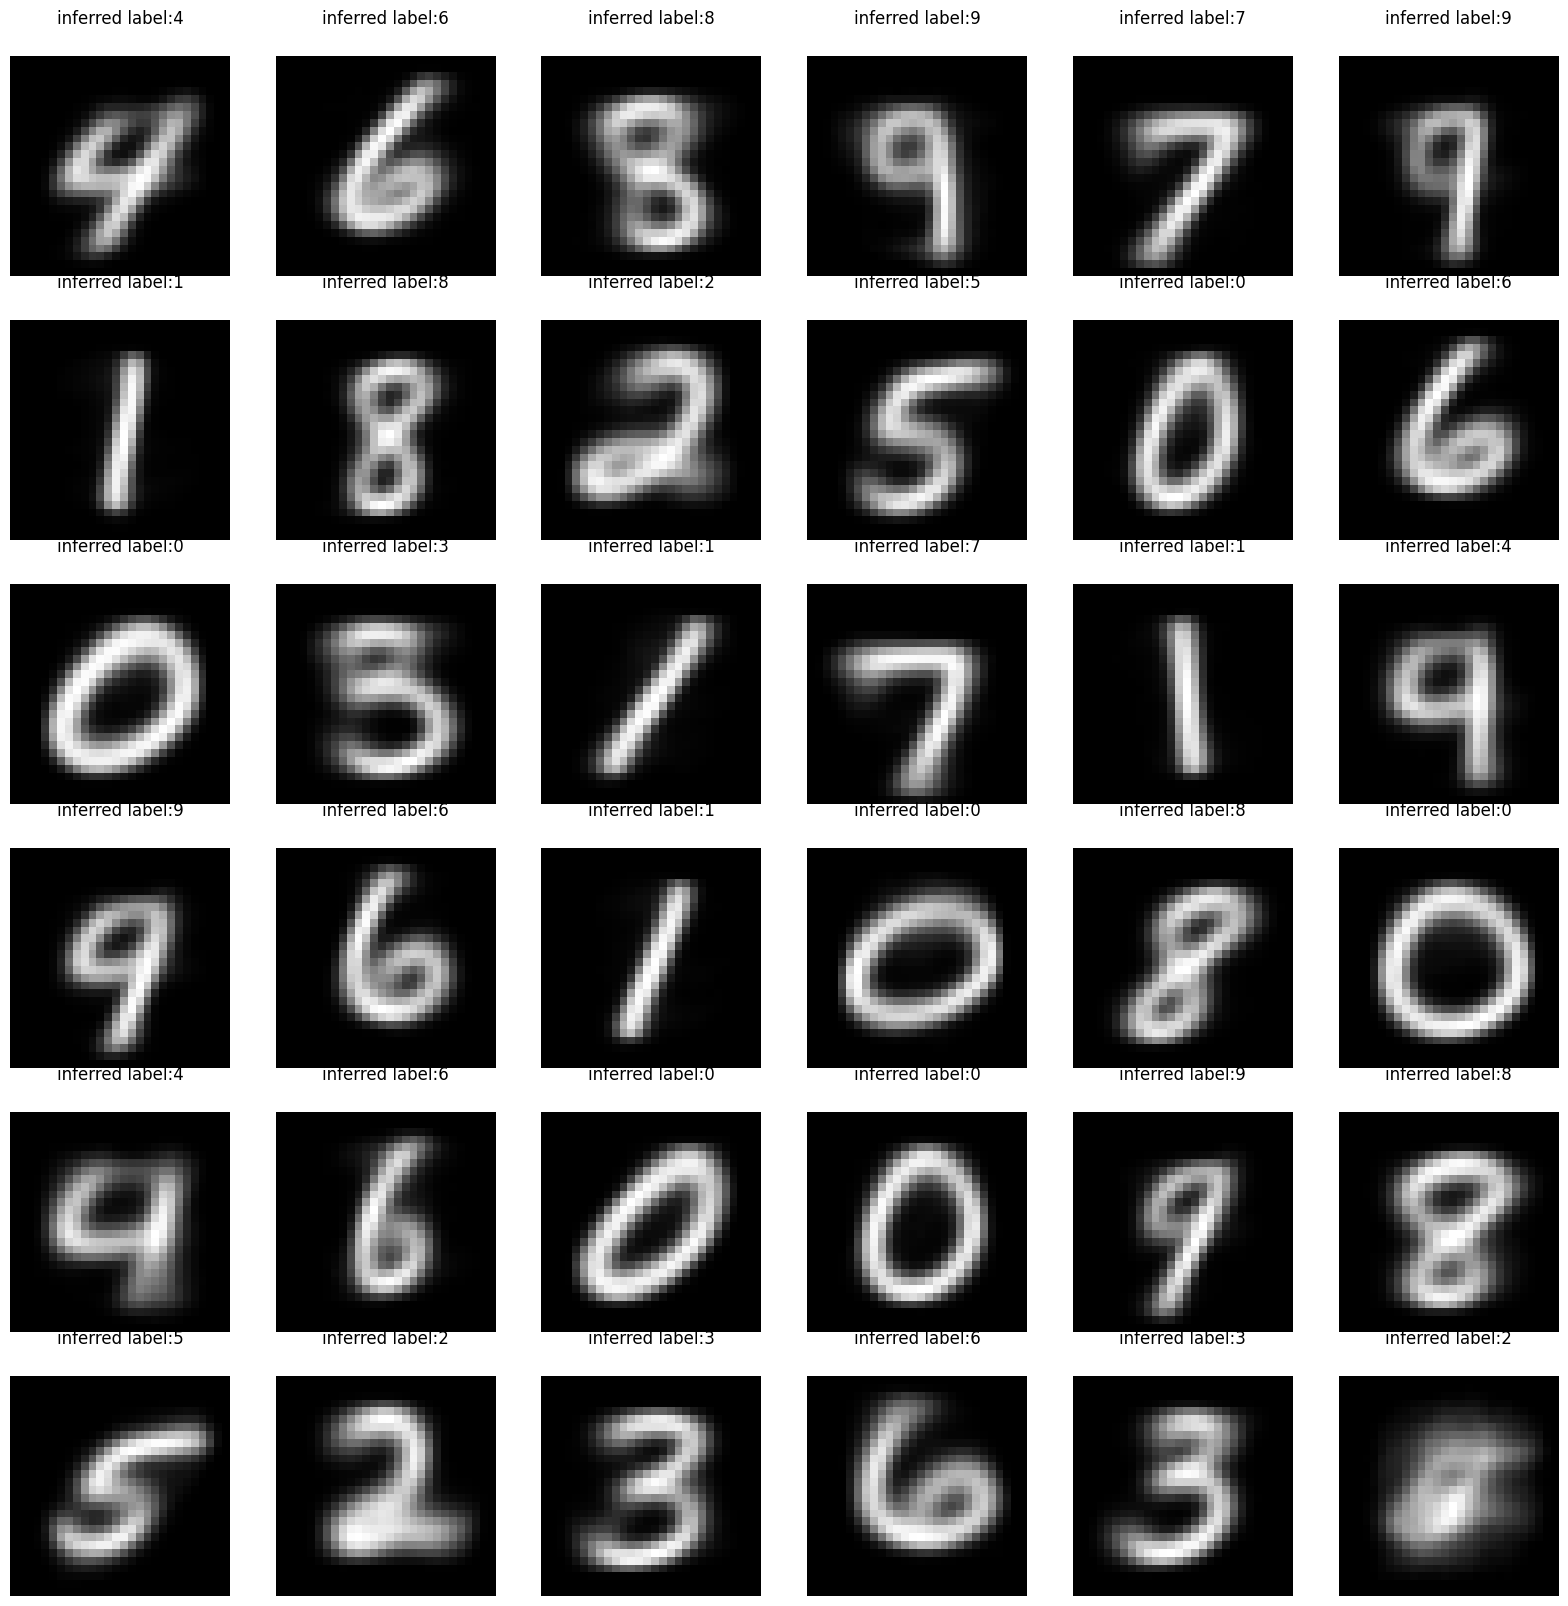

In [18]:
# visualize cluster centroids

# initialise and fit Kmeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images = images * 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels =  infer_cluster_labels(kmeans,Y)

# create figure with subplots using matplotlib.pyplot
fig,axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

#loop through  subplots and add centroid images
for i , ax in enumerate(axs.flat):

    # determine inferred labels using cluster_labels dictionary
    for key,value in cluster_labels.items():
        if i in value:
            ax.set_title('inferred label:{}'.format(key))

    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')

# display the figure
fig.show()